# Introduction

This project will focus on exploring the capabilities of Bayesian optimization, specifically employing BayBE, in the discovery of novel corrosion inhibitors for materials design. Initially, we will work with a randomly chosen subset from a comprehensive database of electrochemical responses of small organic molecules. Our goal is to assess how Bayesian optimization can speed up the screening process across the design space to identify promising compounds. We will compare different strategies for incorporating alloy information, while optimizing the experimental parameters with respect to the inhibitive performance of the screened compounds.

# Initialization

Loading libraries and data files:

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from baybe import Campaign
from baybe.objective import Objective
from baybe.parameters import NumericalDiscreteParameter, SubstanceParameter, CategoricalParameter
from baybe.recommenders import RandomRecommender, TwoPhaseMetaRecommender
from baybe.searchspace import SearchSpace
from baybe.simulation import simulate_scenarios
from baybe.targets import NumericalTarget

# these are datasets already preprocessed, filtered, and grouped by 
so we have only one row for each unique combination of parameters
df_AA2024 = pd.read_excel('data/averaged_filtered_AA2024.xlsx')
df_AA5000 = pd.read_excel('data/averaged_filtered_AA5000.xlsx')
df_AA6000 = pd.read_excel('data/averaged_filtered_AA6000.xlsx')
df_AA7075 = pd.read_excel('data/averaged_filtered_AA7075.xlsx')
df_AA1000 = pd.read_excel('data/averaged_filtered_AA1000.xlsx')
df_Al = pd.read_excel('data/averaged_filtered_Al.xlsx')

# change this for campaigns on different datasets
df_active = df_AA2024


if df_active is df_AA2024:
    exp_dataset_name = 'AA2024'
elif df_active is df_AA7075:
    exp_dataset_name = 'AA7075'
elif df_active is df_AA5000:
    exp_dataset_name = 'AA5000'
elif df_active is df_AA6000:
    exp_dataset_name = 'AA6000'
elif df_active is df_AA1000:
    exp_dataset_name = 'AA1000'
elif df_active is df_Al:
    exp_dataset_name = 'Al'

df_active

,SMILES,Time_h,pH,Inhib_Concentrat_M,Salt_Concentrat_M,Efficiency
0,C(=O)(C(=O)[O-])[O-],24.0,4.0,0.0010,0.10,20.00
1,C(=O)(C(=O)[O-])[O-],24.0,7.0,0.0005,0.05,12.35
2,C(=O)(C(=O)[O-])[O-],24.0,10.0,0.0010,0.10,20.00
3,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,24.0,4.0,0.0010,0.10,30.00
4,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,24.0,7.0,0.0005,0.05,-23.95
...,...,...,...,...,...,...
510,c1ccc2c(c1)[nH]nn2,24.0,7.0,0.0005,0.05,97.95
511,c1ccc2c(c1)[nH]nn2,24.0,10.0,0.0010,0.10,90.00
512,c1ccc2c(c1)[nH]nn2,672.0,7.0,0.0010,0.10,98.00
513,c1ncn[nH]1,24.0,4.0,0.0010,0.10,30.00


In [298]:
# def required from baybe package
lookup = df_active

In [299]:
# chemical space dictionary
unique_SMILES = df_active.SMILES.unique()

def list_to_dict(input_list):
    return {item: item for item in input_list}

smiles_dict =list_to_dict(unique_SMILES)

# Defining parameters for the search space

In [300]:
# parameters

basic_parameters=[
NumericalDiscreteParameter(
    name="Time_h",
    values=df_active["Time_h"].unique(),
    # tolerance = 0.004, assume certain experimental noise for each parameter measurement?
),
NumericalDiscreteParameter(
    name="pH",
    values=df_active["pH"].unique(),
    ),  
NumericalDiscreteParameter(
    name="Inhib_Concentrat_M",
    values=df_active["Inhib_Concentrat_M"].unique(),
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df_active["Salt_Concentrat_M"].unique(),
    ),
]

# mordred
parameters_mordred = basic_parameters + [
    SubstanceParameter(
        name="SMILES",
        data=smiles_dict,
        encoding="MORDRED",  # optional
        decorrelate=0.7,  # optional
        )        
        ]

# morgan fingerprints
parameters_morgan_fp = basic_parameters + [
    SubstanceParameter(
        name="SMILES",
        data=smiles_dict,
        encoding="MORGAN_FP",  # optional
        decorrelate=0.7,  # optional
        )        
        ]

# rdkit
parameters_rdkit = basic_parameters + [
    SubstanceParameter(
        name="SMILES",
        data=smiles_dict,
        encoding="RDKIT",  # optional
        decorrelate=0.7,  # optional
        )        
        ]

# one-hot encoding
parameters_ohe = basic_parameters + [
    CategoricalParameter(
        name="SMILES",
        values=unique_SMILES,
        encoding="OHE",
        )
        ]

# Setting the target

In [ ]:
df_no_target = lookup.drop('Efficiency', axis=1)

# Creating the searchspace
Multiple searchspaces and parameter groups are initialized to investigate the influence of built-in featurization methods on the Bayesian optimization process.

In [301]:

# searchspace = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters)
# print('Print test 1')
# objective = Objective(
#     mode="SINGLE", targets=[NumericalTarget(name="Efficiency", mode="MAX")]
# )


searchspace_mordred = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters_mordred)

searchspace_morgan = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters_morgan_fp)

searchspace_rdkit = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters_rdkit)

searchspace_ohe = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters_ohe)


objective = Objective(
    mode="SINGLE", targets=[NumericalTarget(name="Efficiency", mode="MAX")]
)


In [302]:
searchspace_rdkit

SearchSpace(discrete=SubspaceDiscrete(parameters=[NumericalDiscreteParameter(name='Time_h', encoding=None, _values=[0.5, 1.0, 2.0, 3.0, 6.0, 24.0, 48.0, 72.0, 96.0, 120.0, 144.0, 168.0, 192.0, 240.0, 288.0, 336.0, 360.0, 384.0, 432.0, 480.0, 528.0, 576.0, 600.0, 624.0, 672.0], tolerance=0.0), NumericalDiscreteParameter(name='pH', encoding=None, _values=[0.0, 3.3, 4.0, 4.4, 5.4, 5.5, 5.6, 7.0, 10.0], tolerance=0.0), NumericalDiscreteParameter(name='Inhib_Concentrat_M', encoding=None, _values=[1e-05, 5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0008, 0.001, 0.0012, 0.0018, 0.0024, 0.003, 0.005, 0.01, 0.011, 0.021, 0.022, 0.031, 0.033, 0.042, 0.044, 0.05, 0.1], tolerance=0.0), NumericalDiscreteParameter(name='Salt_Concentrat_M', encoding=None, _values=[0.0, 0.01, 0.05, 0.1, 0.5, 0.6], tolerance=0.0), SubstanceParameter(name='SMILES', data={'C(=O)(C(=O)[O-])[O-]': 'C(=O)(C(=O)[O-])[O-]', 'C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O': 'C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O', 'C(C(C(C(

# Defining the campaign = searchspace + objective

In [303]:
campaign_mordred = Campaign(searchspace=searchspace_mordred, objective=objective)
campaign_morgan = Campaign(searchspace=searchspace_morgan, objective=objective)
campaign_rdkit = Campaign(searchspace=searchspace_rdkit, objective=objective)
campaign_ohe = Campaign(searchspace=searchspace_ohe, objective=objective)

# not all randoms are used but checked for differences in behaviour
campaign_rand_mordred = Campaign(
    searchspace=searchspace_mordred,
    recommender=TwoPhaseMetaRecommender(recommender=RandomRecommender()),
    objective=objective,
)
campaign_rand_morgan = Campaign(
    searchspace=searchspace_morgan,
    recommender=TwoPhaseMetaRecommender(recommender=RandomRecommender()),
    objective=objective,
)
campaign_rand_rdkit = Campaign(
    searchspace=searchspace_rdkit,
    recommender=TwoPhaseMetaRecommender(recommender=RandomRecommender()),
    objective=objective,
)

# Puttting the campaigns that we are interested in a scenario

In [ ]:
scenarios = {"Mordred": campaign_mordred, #"Random": campaign_rand_mordred,
             "Morgan": campaign_morgan, #"Morgan Random": campaign_rand_morgan,
             "RDKIT": campaign_rdkit,
             "OHE": campaign_ohe, 
             "Random": campaign_rand_rdkit
             }

# Start our simulations

In [305]:
N_MC_ITERATIONS = 10 # number of Monte Carlo iterations
N_DOE_ITERATIONS = 50 # number of Design of Experiments iterations
BATCH_SIZE = 1 # number of experiments each DoE contains 

results = simulate_scenarios(
    scenarios,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
    impute_mode="best",
)

  0%|          | 0/50 [00:00<?, ?it/s]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  stdvs = Y.std(dim=-2, keepdim=True)
/home/vscode/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
  2%|2         | 1/50 [00:17<13:58, 17.11s/it]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (inp

In [306]:
# record results to excel
results.to_excel(f"./results/{exp_dataset_name}_simulation_{N_MC_ITERATIONS}MC_{N_DOE_ITERATIONS}exp_{BATCH_SIZE}batch.xlsx")

# Plotting the results

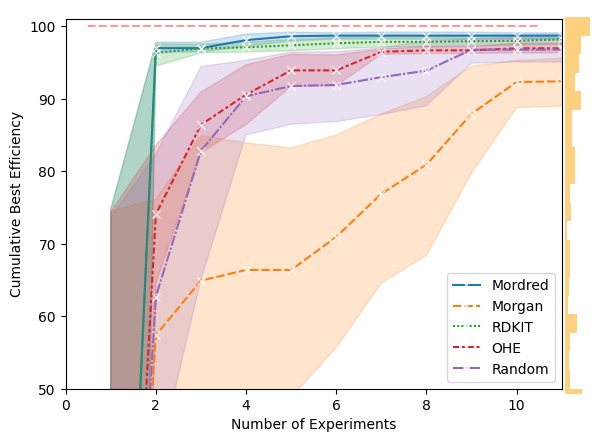

In [313]:
import matplotlib.pyplot as plt
import seaborn as sns

max_yield = lookup["Efficiency"].max()

# until 10
limit = 10

# Create a figure and axis object
fig, ax1 = plt.subplots()

# Plot the lineplot
sns.lineplot(
    data=results, x="Num_Experiments", y="Efficiency_CumBest", hue="Scenario", marker="x", ax=ax1, style = 'Scenario'
)

# Set legend
ax1.legend(loc="lower right")

# Add a horizontal line
ax1.plot([0.5, limit+0.5], [max_yield, max_yield], "--r", alpha=0.4)

# Set x-axis limit
ax1.set_xlim(0, limit+1)
ax1.set_ylim(50, 101)

# Create a new axis for the histogram on the right side
ax2 = fig.add_axes([0.905, 0.1, 0.05, 0.8])
ax2.hist(df_active['Efficiency'], bins=2000, color='orange', alpha=0.5, orientation='horizontal') 
ax2.set_ylim(ax1.get_ylim()) 
ax2.set_axis_off()  # Hide axis ticks and labels

# Set x and y titles
ax1.set_xlabel('Number of Experiments')
ax1.set_ylabel('Cumulative Best Efficiency')

# Save the plot
plt.savefig(f"./img/{exp_dataset_name}_simulation_{N_MC_ITERATIONS}MC_{N_DOE_ITERATIONS}exp_{BATCH_SIZE}batch_first{limit}.png", bbox_inches='tight')

# Show the plot
plt.show()

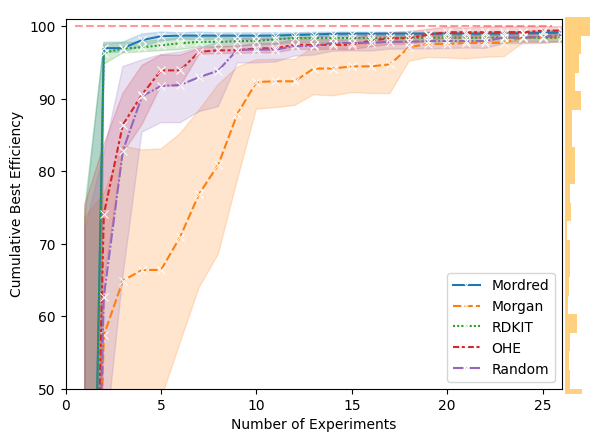

In [314]:
# until 25
limit = 25

# Create a figure and axis object
fig, ax1 = plt.subplots()

# Plot the lineplot
sns.lineplot(
    data=results, x="Num_Experiments", y="Efficiency_CumBest", hue="Scenario", marker="x", ax=ax1, style = 'Scenario'
)

# Set legend
ax1.legend(loc="lower right")

# Add a horizontal line
ax1.plot([0.5, limit+0.5], [max_yield, max_yield], "--r", alpha=0.4)

# Set x-axis limit
ax1.set_xlim(0, limit+1)
ax1.set_ylim(50, 101)

# Create a new axis for the histogram on the right side
ax2 = fig.add_axes([0.905, 0.1, 0.05, 0.8])
ax2.hist(df_active['Efficiency'], bins=2000, color='orange', alpha=0.5, orientation='horizontal') 
ax2.set_ylim(ax1.get_ylim()) 
ax2.set_axis_off()  # Hide axis ticks and labels

# Set x and y titles
ax1.set_xlabel('Number of Experiments')
ax1.set_ylabel('Cumulative Best Efficiency')

# Save the plot
plt.savefig(f"./img/{exp_dataset_name}_simulation_{N_MC_ITERATIONS}MC_{N_DOE_ITERATIONS}exp_{BATCH_SIZE}batch_first{limit}.png", bbox_inches='tight')

# Show the plot
plt.show()

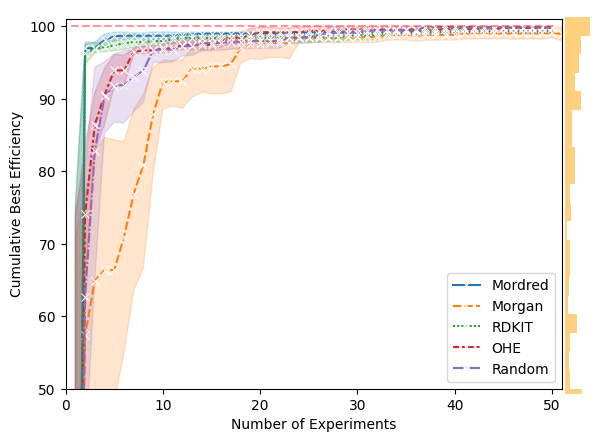

In [315]:
# all experiments

# until 50
limit = 50

# Create a figure and axis object
fig, ax1 = plt.subplots()

# Plot the lineplot
sns.lineplot(
    data=results, x="Num_Experiments", y="Efficiency_CumBest", hue="Scenario", marker="x", ax=ax1, style = 'Scenario'
)

# Set legend
ax1.legend(loc="lower right")

# Add a horizontal line
ax1.plot([0.5, limit+0.5], [max_yield, max_yield], "--r", alpha=0.4)

# Set x-axis limit
ax1.set_xlim(0, limit+1)
ax1.set_ylim(50, 101)

# Create a new axis for the histogram on the right side
ax2 = fig.add_axes([0.905, 0.1, 0.05, 0.8])
ax2.hist(df_active['Efficiency'], bins=2000, color='orange', alpha=0.5, orientation='horizontal') 
ax2.set_ylim(ax1.get_ylim()) 
ax2.set_axis_off()  # Hide axis ticks and labels

# Set x and y titles
ax1.set_xlabel('Number of Experiments')
ax1.set_ylabel('Cumulative Best Efficiency')

# Save the plot
plt.savefig(f"./img/{exp_dataset_name}_simulation_{N_MC_ITERATIONS}MC_{N_DOE_ITERATIONS}exp_{BATCH_SIZE}batch_first{limit}.png", bbox_inches='tight')

# Show the plot
plt.show()

In [310]:
results

,Scenario,Random_Seed,Iteration,Num_Experiments,Efficiency_Measurements,Efficiency_IterBest,Efficiency_CumBest
0,Mordred,1337,0,1,[10.0],10.000000,10.000000
1,Mordred,1337,1,2,[96.43666666666667],96.436667,96.436667
2,Mordred,1337,2,3,[25.25],25.250000,96.436667
3,Mordred,1337,3,4,[99.21666666666665],99.216667,99.216667
4,Mordred,1337,4,5,[93.8],93.800000,99.216667
...,...,...,...,...,...,...,...
2495,Random,1346,45,46,[99.9],99.900000,100.000000
2496,Random,1346,46,47,[40.0],40.000000,100.000000
2497,Random,1346,47,48,[10.0],10.000000,100.000000
2498,Random,1346,48,49,[91.7],91.700000,100.000000


# Transfer Learning
### Use transfer learning to gain information from prior experimental campaigns.

In [317]:
df_active = df_AA2024
df_transfer = df_AA1000

In [318]:
from baybe.parameters import TaskParameter

taskparam = TaskParameter(
    name="Al_alloys",
    values=["AA1000", "AA2024"],
    active_values=["AA2024"],
)

In [321]:

df_combined = pd.concat([df_active, df_transfer], axis=0)
df_combined.describe()


,Time_h,pH,Inhib_Concentrat_M,Salt_Concentrat_M,Efficiency
count,848.000000,848.000000,8.480000e+02,848.000000,848.000000
mean,126.843160,4.189580,6.352976e-02,0.088962,35.066659
std,192.055676,3.696183,3.690920e-01,0.227758,245.617010
min,0.000000,-0.600000,1.000000e-07,0.000000,-4834.000000
25%,6.000000,0.000000,5.000000e-04,0.000000,35.000000
50%,24.000000,4.000000,1.000000e-03,0.010000,60.000000
75%,144.000000,7.000000,4.200000e-03,0.100000,80.507500
max,720.000000,13.000000,3.280000e+00,2.000000,100.000000


In [332]:
unique_SMILES_transfer = df_transfer["SMILES"].unique()
unique_SMILES = df_combined["SMILES"].unique()

In [333]:
from baybe.parameters import NumericalContinuousParameter, CategoricalParameter, NumericalDiscreteParameter
from baybe.searchspace import SearchSpace

transfer_parameters=[
NumericalDiscreteParameter(
    name="Time_h",
    values=df_combined["Time_h"].unique(),
    tolerance=5/60,
),
NumericalDiscreteParameter(
    name="pH",
    values=df_combined["pH"].unique(),
    ),  
NumericalDiscreteParameter(
    name="Inhib_Concentrat_M",
    values=df_combined["Inhib_Concentrat_M"].unique(),
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df_combined["Salt_Concentrat_M"].unique(),
    ),
CategoricalParameter(
    name="SMILES",
    values=unique_SMILES,
    encoding="OHE",
    )
]

In [334]:
searchspace_transfer = SearchSpace.from_dataframe(df_transfer.drop("Efficiency", axis = 1), transfer_parameters)

campaign_transfer = Campaign(searchspace_transfer, objective)

In [328]:
df_features = df_active.drop("Efficiency", axis = 1)

In [335]:
results_transfer: list[pd.DataFrame] = []
fractions = (1, 1)


result_fresh_start = simulate_scenarios(
    {"Fresh": campaign_transfer},
    df_transfer,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
    impute_mode="best",
)

  0%|          | 0/10 [00:00<?, ?it/s]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  stdvs = Y.std(dim=-2, keepdim=True)
/home/vscode/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
 10%|#         | 1/10 [00:06<00:59,  6.58s/it]/home/vscode/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (inp

In [337]:
fraction_df = df_active.sample(frac=1)
training_lookup = [fraction_df for _ in range(N_MC_ITERATIONS)]

result_transfer_learning = simulate_scenarios(
    {"Transfer": campaign_transfer},
    df_transfer,
    initial_data=training_lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    impute_mode="best",
)

100%|##########| 10/10 [03:53<00:00, 23.33s/it]


In [338]:
fraction_df.describe()

,Time_h,pH,Inhib_Concentrat_M,Salt_Concentrat_M,Efficiency
count,258.000000,258.000000,258.000000,258.000000,258.000000
mean,167.602713,6.636047,0.007386,0.117907,28.268191
std,220.488788,2.149613,0.013202,0.166813,265.800655
min,0.500000,0.000000,0.000010,0.000000,-3813.000000
25%,24.000000,5.400000,0.001000,0.050000,30.000000
50%,24.000000,7.000000,0.001000,0.100000,55.000000
75%,240.000000,7.000000,0.004500,0.100000,89.000000
max,672.000000,10.000000,0.044000,0.600000,100.000000


In [ ]:
concatenated_df = pd.concat([result_fresh_start, result_transfer_learning], axis=0, ignore_index=True)
concatenated_df

In [339]:
# until 50
limit = 50
exp_dataset_name = 'transferAA1000_to_AA2024'
sns.lineplot(
    data=concatenated_df, x="Num_Experiments", y="Efficiency_CumBest", hue="Scenario", marker="x"
)
plt.plot([0.5, N_DOE_ITERATIONS+0.5], [max_yield, max_yield], "--r", alpha=0.4)
plt.legend(loc="lower right")
import matplotlib.pyplot as plt

plt.xlim(0, limit+1)
plt.savefig(f"./img/{exp_dataset_name}_simulation_{N_MC_ITERATIONS}MC_{N_DOE_ITERATIONS}exp_{BATCH_SIZE}batch_first25.png")

[]